# Step 1: Network Filtering and Processing
---
Run this code block by block to convert a street network in ESRI Shapefile, GeoJSON, or GeoPackage format into a routable and conflated network graph to use in BikewaySim.

Three networks were used in this project. While code to obtain OSM GeoJSONs has been included with downloading OSM notebook, the ABM and HERE networks need to be sourced from the Atlanta Regional Commission and HERE respectively.

#### Import Modules

In [12]:
from pathlib import Path
import geopandas as gpd
from network_filter import *

# General Settings Dictionary
---
The only input needed for this code is the project directory and the settings dictionary. The settings dictionary has 6 inputs that are commented out below. Note that subsequent code blocks were used for other runs, and should be left commented out so it doesn't overwrite the settings dictionary.

In [13]:
project_dir = Path.home() / 'Documents/GitHub/BikewaySimDev/networks'

settings = {
    'output_fp': project_dir,
    'crs': "epsg:2226",
    'studyarea_fp': Path.home()/'Documents/GitHub/BikewaySimDev/boundaries.geojson',
    'studyarea_layer': None,
    'use_bbox': True
}

#### Import study area:
Specify what area you want to mask the network data by. Only network links that are partially or fully within the study area will be imported. Note: network links are NOT clipped (because this cuts off nodes).

The study area is 3.49 square miles.


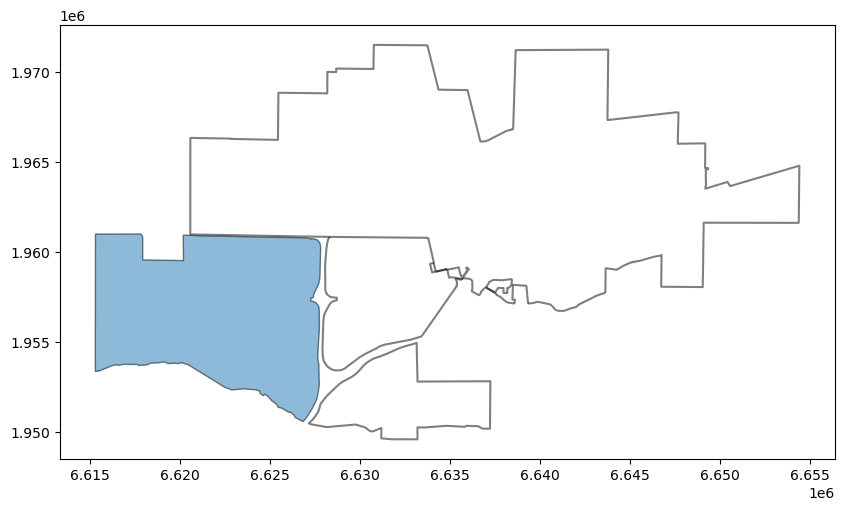

In [14]:
#Adds study area geodataframe to settings dictionary
settings['studyarea'] = import_study_area(settings)

# Run Network Filter Module to Create General, Road, Bike, and Service Layers
---
From the network_filter.py file run the filter networks function. This will first import the spatial data and then filter the data into a raw, general, road, bike, and serivce layer as long as the filters have been pre-defined within the respective function within 'network_filter.py.'

**Note: If this is the a new network that is not OSM, HERE, or ABM then specify a new filter method by going into the 'network_filter.py' script. Otherwise, none of the links will be filtered into road/bike/service layers.**

**Imported networks will be projected to CRS defined in the settings dictionary**

When entering a new filter, search for the following functions: 'filter_to_general', 'filter_to_road', 'filter_to_bike', and 'filter_to_service.' Then add the network name as a new if statement.

If the filters have been specified (by default there are filters for networks that are named 'osm', 'here', and 'osm') then fill in the dictionary and run the 'filter_networks' function with settings dictionary and network dictionary. The network dictionary has the following keys.

- 'network_name': text name of the network (by defualt accepts 'abm','here','osm')
- 'links_fp': the filepath of the original links network data (must have a value)
- 'links_layer': if the file is a geopackage or geodatabase then use this to specify the layer to import
- 'nodes_fp': the filepath of the nodes data if available (replace with None if not available)
- 'nodes_layer': if the file is a geopackage or geodatabase then use this to specify the layer to import
- 'nodes_id': indicates the column name that contains the unique ids for each node (replace with None if not available)
- 'A': indicates the starting node id column name for the links (replace with None if not available)
- 'B': indicates the ending node id column name for the links (replace with None if not available)

## OpenStreetMap (OSM) Filtering
---
OSM is an open-source mapping project (see www.openstreetmap.org). OSM network data can be downloaded using the "Step 0 Downloading OSM.ipynb" Jupyter Notebook.


In [4]:
osm = {
       "network_name": 'osm',
       "links_fp": project_dir / "osm.gpkg", 
       "links_layer":"links", 
       "nodes_fp": project_dir / "osm.gpkg", 
       "nodes_layer":"nodes",
       "nodes_id": "osmid",
       "A": None,
       "B": None,
       "linkid": 'osmid'
       }

links, nodes = filter_networks(settings,osm)

Filtering the osm network.
Provided linkid is not unique.
Generating unique link ids.
There is a nodes layer...
but no reference ids for links.


c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Reference IDs successfully added to links.
osm imported... took 0.15 minutes


In [5]:
#type(tuple(settings['studyarea'].total_bounds))

## Define link types

#### Remove types
- Remove interstates and interstate ramps
- Remove sidewalks unless bicycles explicitly allowed

In [6]:
#remove restricted access roads + sidewalks
restr_access = links['highway'].isin(['motorway','motorway_link'])

#remove sidewalks unless bikes explicitly allowed
sidewalks = (links['footway'].isin(['sidewalk','crossing'])) & (links['bicycle'] != 'yes')

remove_type = restr_access | sidewalks

links.loc[remove_type,'link_type'] = 'remove'

#### Road type
- Keep service roads that have a street name (highway = service and name is not null)
- Keep links with the following keys for the highway tag: 'primary','primary_link','residential','secondary','secondary_link','tertiary','tertiary_link','trunk','trunk_link'

In [7]:
#find service links that still have a name
service_links_with_name = (links['highway'] == 'service') & (links['name'].isnull() == False)

#unclassified added 8/14/23 because there are several roads in Atlanta region marked this despite being public roads
osm_filter_method = ['primary','primary_link','residential','secondary','secondary_link',
                    'tertiary','tertiary_link','trunk','trunk_link','unclassified','living_street'] 
osm_filter_method = links["highway"].isin(osm_filter_method)

# use this if there is a list of osm ids to specifically include in the road layer
# #TODO make a formal input later
# if (settings['output_fp'] / 'osm/include_osm_links.txt').exists():
#     keep_ids = pd.read_csv(settings['output_fp'] / 'osm/include_osm_links.txt',names=['osmid'])
#     add_links = links[links['osmid'].isin(keep_ids['osmid'])]
#     print(f'Adding {add_links.shape[0]} specified osm links')
# else:
#     print('nothing happened')
#     add_links = pd.DataFrame()

#add back in service links with a name
conditions = osm_filter_method | service_links_with_name
links.loc[conditions & links['link_type'].isna(),'link_type'] = 'road'

#### Bike type
- Include links with the following keys for the 'highway' tag: 'cycleway','footway','path','pedestrian','steps'

In [8]:
osm_filter_method = ['cycleway','footway','path','pedestrian','steps']
conditions = links["highway"].isin(osm_filter_method)
links.loc[conditions & links['link_type'].isna(),'link_type'] = 'bike'


#### Service type
- Include links with the key of 'service' for the 'highway' tag unless they have a name

In [9]:
osm_filter_method = ['service']
conditions = links["highway"].isin(osm_filter_method) & (links['name'].isnull())
links.loc[conditions & links['link_type'].isna(),'link_type'] = 'service'

### NAs
Be sure to check if all links have been classified. Some OSM highway tags aren't clear and might need to be added on a case by case basis (e.g., track, construction, living_street).

In [10]:
links[links['link_type'].isna()][['highway','name','geometry']].explore()

### Export

In [11]:
export(links,nodes,'osm',settings)

Export took 0.06 minutes
